In [1]:
import json
import argparse
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import seaborn as sns
palette = sns.color_palette("colorblind")

In [2]:
def read_data(task, mode, mem, idx):    
    with open(f"{task}_{mode}_{mem}_{idx}.json") as f:
        data = json.load(f)
        # print(f"readed {task}_{mode}_{mem}_{idx}.json")
        # print(data)
    return data

In [3]:
def get_iter_time(data, start):
    return np.array(data["iter_time"][start:])

In [4]:
def get_forward_time(data, start):
    return np.array(data["forward_per_iter"][start:])

def get_attn_mem_per_iter(data, start):
    return np.array(data["attn_mem_per_iter"][start:])

def get_attn_comp_per_iter(data, start):
    return np.array(data["attn_comp_per_iter"][start:])

In [5]:
def get_prepare_time(data, start):
    return np.array(data["prepare_per_iter"][start:])

In [8]:
forward_e2e_avg = {
    # "fd": 0.0,
    # "medusa": 0.0,
    # "deft_node_unpaged": 0.0,
    # "deft_flatten_unpaged": 0.0,
    "radix": 0.0,
    "deft_node": 0.0,
    "deft_flatten": 0.0,
}
attn_e2e_avg = {
    "fd": 0.0,
    "medusa": 0.0,
    "deft_node_unpaged": 0.0,
    "deft_flatten_unpaged": 0.0,
    "radix": 0.0,
    "deft_node": 0.0,
    "deft_flatten": 0.0,
}
KV_IO_avg = {
    "fd": 0.0,
    "medusa": 0.0,
    "deft_node_unpaged": 0.0,
    "deft_flatten_unpaged": 0.0,
    "radix": 0.0,
    "deft_node": 0.0,
    "deft_flatten": 0.0,
}
Other_IO_avg = {
    "fd": 0.0,
    "medusa": 0.0,
    "deft_node_unpaged": 0.0,
    "deft_flatten_unpaged": 0.0,
    "radix": 0.0,
    "deft_node": 0.0,
    "deft_flatten": 0.0,
}
def load(task, idx):
    start = 10
    deft_flatten = read_data(task, "flatten", "paged", idx)
    # deft_flatten_unpaged = read_data(task, "flatten", "unpaged", idx)
    deft_node = read_data(task, "node", "paged", idx)
    # deft_node_unpaged = read_data(task, "node", "unpaged", idx)
    radix = read_data(task, "seq", "paged", idx)
    # fd = read_data(task, "seq", "unpaged", idx)
    # medusa = read_data(task, "tree", "unpaged", idx)
    
    results = {
        "deft_flatten": deft_flatten,
        # "deft_flatten_unpaged": deft_flatten_unpaged,
        "deft_node": deft_node,
        # "deft_node_unpaged": deft_node_unpaged,
        "radix": radix,
        # "fd": fd,
        # "medusa": medusa
    }
    
    
    
    for key, result in results.items():
        forward_e2e = np.array(result["forward_per_iter"][start:]).sum()
        attn_comp_e2e = np.array(result["attn_comp_per_iter"][start:]).sum()
        attn_mem_e2e = np.array(result["attn_mem_per_iter"][start:]).sum()
        # attn_mem_e2e = 0
        attn_e2e = attn_comp_e2e + attn_mem_e2e
        KV_IO = result["KV_IO"]
        Other_IO = result["QK_scale_IO"] + result["QK_scale_masked_IO"] + result["Mask_IO"] + result["SoftMax_IO"]
        # print(f"{key}: {result['e2e_latency'] / 1000:.2f}, {forward_e2e / 1000:.2f}, {attn_e2e / 1000:.2f}")
        forward_e2e_avg[key] += forward_e2e
        attn_e2e_avg[key] += attn_e2e
        KV_IO_avg[key] += KV_IO
        Other_IO_avg[key] += Other_IO

        print(f"|{idx:^16}|{key:^20}|{forward_e2e / 1000:^20.2f}|{attn_comp_e2e / 1000:^20.2f}|{attn_mem_e2e / 1000:^20.2f}|{KV_IO / 1e12:^20.2f}|{Other_IO / 1e12:^20.2f}|"
              )
    
print(f"|{'width':^16}|{'op':^20}|{'forward (s)':^20}|{'attn_comp (s)':^20}|{'attn_mem (s)':^20}|{'KV_IO (TB)':^20}|{'Other_IO (TB)':^20}|\n"
      f"|{'-' * 16}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|{'-' * 20}|"
      )
for i in [30]:
    load("few_shot", i)

# for key in forward_e2e_avg.keys():
#     forward_e2e_avg[key] /= 1
#     attn_e2e_avg[key] /= 1
#     KV_IO_avg[key] /= 1 * 1e12
#     Other_IO_avg[key] /= 1 * 1e12
#     print(f"{key}: forward: {forward_e2e_avg[key] / 1000:.2f}, attn_comp: {attn_e2e_avg[key] / 1000:.2f}")
    # print(f"{key}: KV_IO {KV_IO_avg[key]:.2f} TB, Other_IO {Other_IO_avg[key]:.2f} TB")
    
    

|     width      |         op         |    forward (s)     |   attn_comp (s)    |    attn_mem (s)    |     KV_IO (TB)     |   Other_IO (TB)    |
|----------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
|       30       |    deft_flatten    |       22.47        |        8.24        |        5.20        |        2.09        |        0.00        |
|       30       |     deft_node      |       28.64        |       10.12        |        5.17        |        2.09        |        0.00        |
|       30       |       radix        |       27.57        |       12.39        |        5.67        |       26.36        |        0.00        |


In [10]:

def draw(task, idx):
    deft_flatten = read_data(task, "flatten", "paged", idx)
    deft_node = read_data(task, "node", "paged", idx)
    # deft_flatten_unpaged = read_data(task, "flatten", "unpaged", 0)
    # radix = read_data(task, "seq", "paged", idx)
    # fd = read_data(task, "seq", "unpaged", 0)
    start = 10
    deft_flatten_iter_time = get_iter_time(deft_flatten, start)
    # radix_iter_time = get_iter_time(radix, start)
    deft_node_iter_time = get_iter_time(deft_node, start)
    # print(deft_flatten_iter_time.sum() / 1000, radix_iter_time.sum() / 1000)
    print(deft_flatten_iter_time.sum() / 1000, deft_node_iter_time.sum() / 1000)
    
    deft_flatten_attn_mem_per_iter = get_attn_mem_per_iter(deft_flatten, start)
    # radix_attn_mem_per_iter = get_attn_mem_per_iter(radix, start)
    deft_node_attn_mem_per_iter = get_attn_mem_per_iter(deft_node, start)
    
    deft_flatten_attn_comp_per_iter = get_attn_comp_per_iter(deft_flatten, start)
    # deft_flatten_unpaged_attn_comp_per_iter = get_attn_comp_per_iter(deft_flatten_unpaged, start)
    # radix_attn_comp_per_iter = get_attn_comp_per_iter(radix, start)
    deft_node_attn_comp_per_iter = get_attn_comp_per_iter(deft_node, start)
    # fd_attn_comp_per_iter = get_attn_comp_per_iter(fd, start)
    
    deft_flatten_forward_per_iter = get_forward_time(deft_flatten, start)
    # deft_flatten_unpaged_forward_per_iter = get_forward_time(deft_flatten_unpaged, start)
    # radix_forward_per_iter = get_forward_time(radix, start)
    deft_node_forward_per_iter = get_forward_time(deft_node, start)
    # fd_forward_per_iter = get_forward_time(fd, start)
    
    deft_flatten_perpare_per_iter = get_prepare_time(deft_flatten, start)
    # radix_perpare_per_iter = get_prepare_time(radix, start)
    deft_node_perpare_per_iter = get_prepare_time(deft_node, start)
    
    s = len(deft_flatten_iter_time)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Time (ms)')

    # ax2 = ax1.twinx()
    # radix_attn
    # ax1.plot(range(s), deft_flatten_iter_time, color=palette[2], label='Tree')
    # ax1.plot(range(s), radix_iter_time, color=palette[3], label='Seq')
    ax1.plot(range(s), deft_flatten_forward_per_iter, color=palette[0], label='Flatten Forward')
    # ax1.plot(range(s), radix_forward_per_iter, color=palette[1], label='Seq Forward')
    ax1.plot(range(s), deft_node_forward_per_iter, color=palette[1], label='Node Forward')
    # ax1.plot(range(s), fd_forward_per_iter, color=palette[1], label='Seq Forward Unpaged')
    ax1.plot(range(s), deft_flatten_attn_comp_per_iter, color=palette[2], label='Flatten Attn')
    # ax1.plot(range(s), radix_attn_comp_per_iter, color=palette[3], label='Seq Attn')
    ax1.plot(range(s), deft_node_attn_comp_per_iter, color=palette[3], label='Node Attn')
    # ax1.plot(range(s), fd_attn_comp_per_iter, color=palette[3], label='Seq Attn Unpaged')
    ax1.plot(range(s), deft_flatten_attn_mem_per_iter, color=palette[4], label='Flatten Mem')
    ax1.plot(range(s), deft_node_attn_mem_per_iter, color=palette[5], label='Node Mem')
    # ax1.plot(range(s), radix_attn_mem_per_iter, color=palette[5], label='Seq Mem')
    # ax1.plot(range(s), deft_flatten_perpare_per_iter, color=palette[4], label='Tree Prepare')
    # ax1.plot(range(s), radix_perpare_per_iter, color=palette[5], label='Seq Prepare')
    # ax1.plot(range(s), deft_flatten_perpare_per_iter, color=palette[6], label='Tree Prepare')
    # ax1.plot(range(s), radix_perpare_per_iter + radix_attn_comp_per_iter, color=palette[7], label='Seq Prepare + Attn Comp')
    ax1.legend(loc='upper right')

    # ax2.plot(range(s), tree[start:, 1], color='red', label='KV len', linestyle='--')
    # ax2.plot(range(s), tree[start:, 2], color=palette[2], label='Q len', linestyle='--')
    # ax2.set_ylim(2000, 20000)
    ax1.set_ylim(0, 50)
    # ax2.legend(loc='upper right')
    # plt.title('prompt_len=1000, node_len=1000, branch=10, depth=3, prune')
    plt.title(f'{task} on tree #{idx}')
    plt.show()

14.718604803085327 14.96757459640503


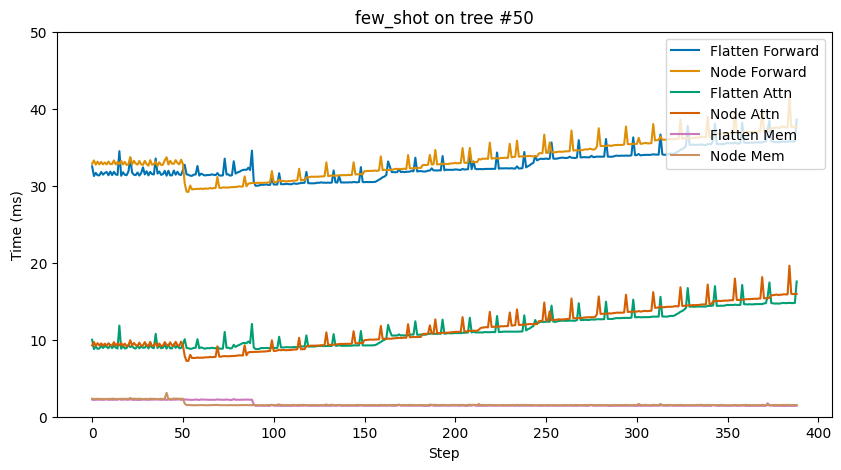

In [12]:
draw("few_shot", 50)